In [1]:
# Подготовка
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import zipfile


__z = zipfile.ZipFile("dataset.zip")
#df_str = __z.open("Vehicle_policies_2020.csv").read().decode("utf-8")
df_str_fs = __z.open("Vehicle_policies_2020.csv")

df_src = pd.read_csv(df_str_fs)


# Предварительная обработка данных

Данные [отсюда](https://www.kaggle.com/datasets/lakshmanraj/vehicle-insurance-policy):

~~1. pol_number - Номер полюса~~

~~2. pol_eff_dt - Дата вступления в силу полиса автострахования~~

3. gender - Пол водителя: F, M

4. agecat - Возрастная категория водителя: 1, 2, 3, 4, 5, 6 (1 - моложе, ..., 6 - старше)

~~5. date_of_birth - Дата рождения водителя~~

6. credit_score - Кредитный рейтинг водителя: от 301=плохо до 850=прекрасно

7. area - Категория: A, B, C, D, E, F

8. traffic_index - Дорожный индекс района проживания водителя:

- 100 = среднее по стране

- Больше 100 = плохие условия движения

- Меньше 100 = хорошие условия движения

9. veh_age - Возраст транспортного средства: 1, 2, 3, 4 (1 - новее, ..., 4 - старее)

10. veh_body - Кузов транспортного средства, coded as:
- BUS
- CONVT = convertible
- COUPE
- HBACK = hatchback
- HDTOP = hardtop
- MCARA = motorized caravan
- MIBUS = minibus
- PANVN = panel van
- RDSTR = roadster
- STNWG = station wagon
- TRUCK
- UTE = utility

11. veh_value - Стоимость транспортного средства, в $10 000

~~12. months_insured - Количество месяцев, на которые приобретена страховка транспортного средства~~

~~13. claim_office - Office location of claim handling agent: A, B, C, D~~

14. numclaims - Кол-во претензий: 0=нет_претензий

15. claimcst0 - Стоимость претензий: 0=нет_претензий

~~16. annual_premium - Total charged premium i.e. the cost of insurance~~

In [2]:
# Look dataframe
pd.set_option('display.max_columns', df_src.shape[1])
df_src.head(300)

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium
0,43124327,12/30/2020,F,4.0,7/12/1968,381.0,D,133.6,2,HBACK,1.331,NaN,0,0.000000,716.53
1,21919609,12/30/2020,F,2.0,11/5/1982,549.0,D,163.6,1,UTE,3.740,NaN,0,0.000000,716.53
2,72577057,12/30/2020,M,2.0,11/26/1983,649.0,B,117.5,4,COUPE,0.880,NaN,0,0.000000,716.53
3,92175225,12/30/2020,M,4.0,11/2/1960,743.0,B,100.7,3,SEDAN,1.045,NaN,0,0.000000,716.53
4,66223239,12/30/2020,F,4.0,1/4/1968,817.0,C,115.5,4,HBACK,0.473,NaN,0,0.000000,716.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,26908963,12/29/2020,F,2.0,2/23/1981,672.0,B,117.9,4,SEDAN,0.792,NaN,0,0.000000,716.53
296,23036703,12/29/2020,M,1.0,12/4/1991,757.0,D,99.0,2,HBACK,1.408,NaN,0,0.000000,716.53
297,11799354,12/29/2020,F,4.0,10/3/1962,698.0,B,94.4,4,SEDAN,0.605,B,1,183.057662,716.53
298,16920051,12/29/2020,M,3.0,8/24/1971,651.0,C,144.0,4,UTE,1.001,NaN,0,0.000000,716.53


In [3]:
# Look dataframe
#df_src.head()
pd.set_option('display.max_columns', df_src.shape[1])
df_src.tail(300)

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium
60092,86217411,1/3/2020,F,2.0,2/4/1987,692.0,C,129.0,2,STNWG,4.070,NaN,0,0.0,716.53
60093,57211111,1/3/2020,F,2.0,6/26/1985,626.0,F,92.0,4,STNWG,1.309,NaN,0,0.0,716.53
60094,13215458,1/3/2020,F,3.0,2/27/1977,480.0,E,64.5,3,STNWG,1.859,NaN,0,0.0,716.53
60095,22406584,1/3/2020,F,NaN,6/1/1976,563.0,B,104.3,4,HBACK,0.726,NaN,0,0.0,716.53
60096,73961792,1/3/2020,F,3.0,1/18/1977,642.0,C,144.0,4,STNWG,2.409,NaN,0,0.0,716.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60387,73248694,1/2/2020,F,5.0,5/10/1956,809.0,C,145.5,4,HBACK,0.891,NaN,0,0.0,716.53
60388,71411764,1/2/2020,M,4.0,3/22/1961,681.0,D,86.3,1,HBACK,1.881,NaN,0,0.0,716.53
60389,89353155,1/2/2020,M,4.0,9/29/1965,773.0,F,110.0,1,STNWG,5.170,NaN,0,0.0,716.53
60390,40916605,1/2/2020,M,3.0,8/1/1978,714.0,B,NaN,1,HBACK,1.903,NaN,0,0.0,716.53


# Проектирование признаков

## Убираем дубликаты

In [4]:
print(f"Number of (rows, columns): {df_src.shape}")
duplicate_rows_df = df_src[df_src.duplicated()]
print(f"Number of duplicate (rows, columns): {duplicate_rows_df.shape}")
df_src = df_src.drop_duplicates()
print(f"Number of (rows, columns) after drop dublicates: {df_src.shape}")

Number of (rows, columns): (60392, 15)
Number of duplicate (rows, columns): (0, 15)
Number of (rows, columns) after drop dublicates: (60392, 15)


## Смотрим, чтобы не было нерелевантных данных

### Как поступить с такими данными?

![](./imgs/if_missing_data.png)


In [5]:
pd.set_option('display.max_rows', df_src.shape[1])
df_src.count() # Кол-во не None значений в каждой колонке

pol_number        60392
pol_eff_dt        60392
gender            60392
agecat            55561
date_of_birth     60392
credit_score      57591
area              60392
traffic_index     56889
veh_age           60392
veh_body          60392
veh_value         60392
claim_office      10030
numclaims         60392
claimcst0         60392
annual_premium    60392
dtype: int64

In [6]:
pd.set_option('display.max_rows', df_src.shape[1])
print(df_src.isnull().sum()) # Смотрим есть ли null хотя бы в каком-нибудь столбце


pol_number            0
pol_eff_dt            0
gender                0
agecat             4831
date_of_birth         0
credit_score       2801
area                  0
traffic_index      3503
veh_age               0
veh_body              0
veh_value             0
claim_office      50362
numclaims             0
claimcst0             0
annual_premium        0
dtype: int64


In [7]:
# Удалим посностью claim_office
del df_src["claim_office"]

# Удалим date_of_birth
del df_src["date_of_birth"]

# Удалим pol_number
del df_src["pol_number"]

# Удалим null'ы
df_src = df_src.dropna()

# Удалим дубликаты, если они появились после удаления столбцов
df_src = df_src.drop_duplicates()

print(f"\nNumber of (rows, columns): {df_src.shape}")

print("\nКол-во не None значений:")
print(df_src.count())

print("\nКол-во null\'ов:")
print(df_src.isnull().sum())


Number of (rows, columns): (49919, 12)

Кол-во не None значений:
pol_eff_dt        49919
gender            49919
agecat            49919
credit_score      49919
area              49919
traffic_index     49919
veh_age           49919
veh_body          49919
veh_value         49919
numclaims         49919
claimcst0         49919
annual_premium    49919
dtype: int64

Кол-во null'ов:
pol_eff_dt        0
gender            0
agecat            0
credit_score      0
area              0
traffic_index     0
veh_age           0
veh_body          0
veh_value         0
numclaims         0
claimcst0         0
annual_premium    0
dtype: int64


Range of annual_premium: [716.53 - 716.53]


<Figure size 7200x3600 with 0 Axes>

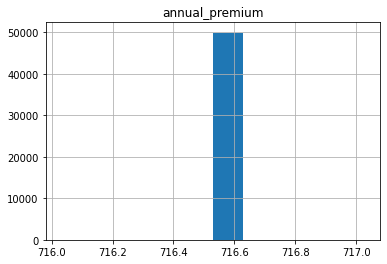

In [8]:
plt.figure(figsize=(100,50))

df_src.hist(column="annual_premium")

print(f"Range of annual_premium: [{df_src['annual_premium'].min()} - {df_src['annual_premium'].max()}]")


In [9]:
df_date_check = df_src.copy()

basedate = pd.Timestamp("2022-11-28")
# basedate = pd.Timestamp("11/28/2022") # То что в столбце "pol_eff_dt", тип str
            # pd.Timestamp("2022-11-28") and pd.Timestamp("11/28/2022") are equals

df_date_check["time_since_in_days"] = df_date_check["pol_eff_dt"].apply(lambda x: (basedate - pd.Timestamp(x)).days)


#df_date_check.hist(column="time_since_in_days")
print(f"Range of pol_eff_dt: [{df_date_check['time_since_in_days'].min()} - {df_date_check['time_since_in_days'].max()}]")


Range of pol_eff_dt: [698 - 1061]


In [10]:
# Никчёмные столбецы
del df_src["annual_premium"]
del df_src["pol_eff_dt"]
           
df_src = df_src.drop_duplicates()
           
print(f"\nNumber of (rows, columns): {df_src.shape}")


Number of (rows, columns): (49919, 10)


### В итоге будут убраны столбцы:

- `claim_office`: По большей части - это `null`'ы. 

- `date_of_birth`: Зачем это нужно, если есть `agecat`. 

- `pol_number`: Номер полюса никак не влияет. 

- `annual_premium`: Одно и тоже число. 

- `pol_eff_dt`: Дата оформления полюса не влияет на кластеризацию. Плюс ко всем, здесь период всего лишь 363 дня. 


## Кодирование строк + float->int

In [11]:
# Смотрим типы столбцов

pd.set_option('display.max_rows', df_src.shape[1])

nullout = '''
Должно быть:

pol_number          int64
pol_eff_dt         cat->int
gender             cat->int
agecat              int64
credit_score        int64
area               cat->int
traffic_index       int64
veh_age             int64
veh_body           cat->int
veh_value         float64
numclaims           int64
claimcst0         float64
'''

df_src.dtypes

gender            object
agecat           float64
credit_score     float64
area              object
traffic_index    float64
veh_age            int64
veh_body          object
veh_value        float64
numclaims          int64
claimcst0        float64
dtype: object

In [12]:
df_nums = df_src.copy()

# Инты там, где они нужны
ints_cols = ["agecat", "credit_score", "traffic_index"]
df_nums[ ints_cols ] = df_nums[ints_cols].astype(int)

# Категориальные:

# veh_body
df_nums["veh_body"] = df_nums["veh_body"].astype('category')
df_nums["veh_body"] = df_nums["veh_body"].cat.codes
df_nums["veh_body"] = df_nums["veh_body"].astype(int)

# Не veh_body
cat_code = {"gender": {"M": 0, "F": 1}, 
            "area": {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}}
df_nums = df_nums.replace(cat_code)

pd.set_option('display.max_rows', df_src.shape[1])
df_nums.dtypes

gender             int64
agecat             int64
credit_score       int64
area               int64
traffic_index      int64
veh_age            int64
veh_body           int64
veh_value        float64
numclaims          int64
claimcst0        float64
dtype: object

## Нормализация

In [13]:
df_nums_scaled = df_nums.copy()
df_nums_scaled = (df_nums-df_nums.min ())/(df_nums.max ()-df_nums.min ())
df_nums_scaled.head(300)


,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,numclaims,claimcst0
0,1.0,0.6,0.145719,0.6,0.642512,0.333333,0.250000,0.051732,0.0,0.000000
1,1.0,0.2,0.451730,0.6,0.787440,0.000000,1.000000,0.145361,0.0,0.000000
2,0.0,0.2,0.633880,0.2,0.565217,1.000000,0.166667,0.034203,0.0,0.000000
3,0.0,0.6,0.805100,0.2,0.483092,0.666667,0.750000,0.040616,0.0,0.000000
4,1.0,0.6,0.939891,0.4,0.555556,1.000000,0.250000,0.018384,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...
354,0.0,0.2,0.701275,1.0,0.637681,1.000000,0.833333,0.074818,0.0,0.000000
356,0.0,0.6,0.792350,0.6,0.420290,0.666667,0.833333,0.123557,0.0,0.000000
358,1.0,0.4,0.561020,0.4,0.642512,0.666667,0.750000,0.052159,0.0,0.000000
359,0.0,1.0,0.648452,0.8,0.434783,0.666667,0.250000,0.045746,0.0,0.000000


# Графики

![](./imgs/which_visualization.png)


In [14]:
numeric_columns_of_interest = ["credit_score", "traffic_index", "veh_value", "numclaims", "claimcst0"]
for col_i in numeric_columns_of_interest:
    print(f"Range of {col_i}: [{df_src[col_i].min()} - {df_src[col_i].max()}]")

Range of credit_score: [301.0 - 850.0]
Range of traffic_index: [0.0 - 207.0]
Range of veh_value: [0.0 - 25.729]
Range of numclaims: [0 - 5]
Range of claimcst0: [0.0 - 69478.89783]


,gender,agecat,credit_score,area,traffic_index,veh_age,veh_body,veh_value,numclaims,claimcst0
gender,1.000000,-0.046558,-0.009059,-0.011937,0.000616,-0.049313,-0.186648,-0.105088,-0.188642,-0.092956
agecat,-0.046558,1.000000,0.324397,-0.046431,-0.015879,0.017566,-0.005440,-0.058481,-0.107338,-0.034986
credit_score,-0.009059,0.324397,1.000000,-0.011107,0.000245,-0.001342,0.000439,-0.005772,-0.304388,-0.295601
area,-0.011937,-0.046431,-0.011107,1.000000,-0.007349,0.016559,0.151981,0.097393,0.042532,0.043226
traffic_index,0.000616,-0.015879,0.000245,-0.007349,1.000000,0.004361,-0.047392,-0.043172,0.082343,-0.002541
veh_age,-0.049313,0.017566,-0.001342,0.016559,0.004361,1.000000,0.066216,-0.548896,0.011238,-0.125951
veh_body,-0.186648,-0.005440,0.000439,0.151981,-0.047392,0.066216,1.000000,0.292958,0.035734,0.028648
veh_value,-0.105088,-0.058481,-0.005772,0.097393,-0.043172,-0.548896,0.292958,1.000000,0.016355,0.124289
numclaims,-0.188642,-0.107338,-0.304388,0.042532,0.082343,0.011238,0.035734,0.016355,1.000000,0.475136
claimcst0,-0.092956,-0.034986,-0.295601,0.043226,-0.002541,-0.125951,0.028648,0.124289,0.475136,1.000000


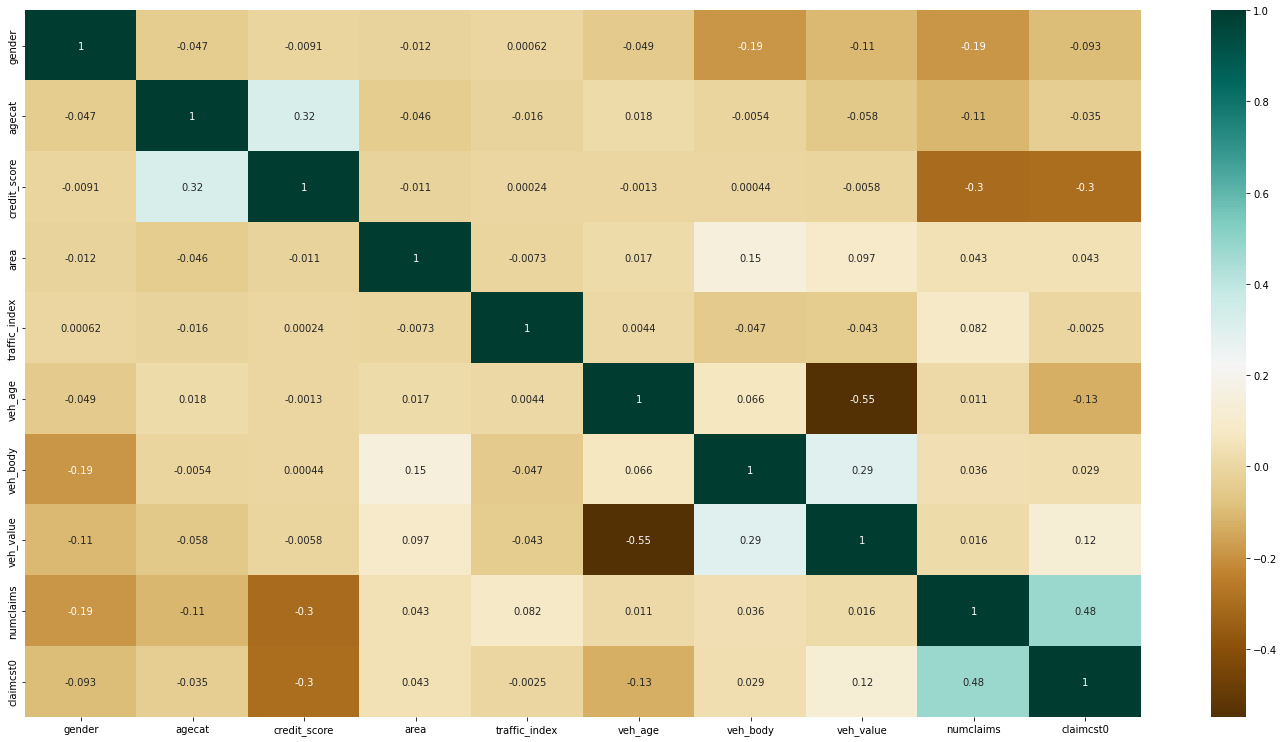

In [15]:
# Тепловая карта

plt.figure(figsize=(25, 13))
c= df_nums.corr()
sns.heatmap(c, cmap="BrBG", annot=True)
c

<Figure size 720x720 with 0 Axes>

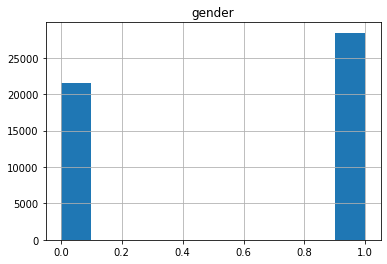

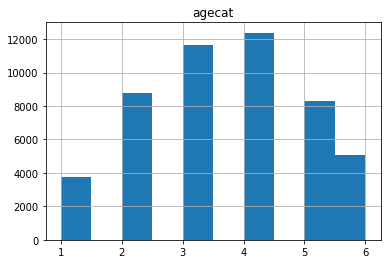

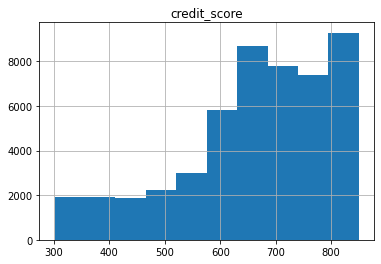

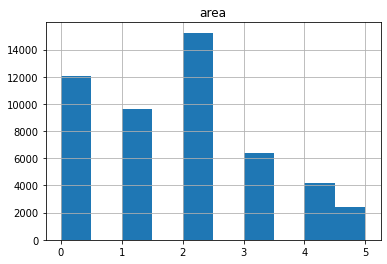

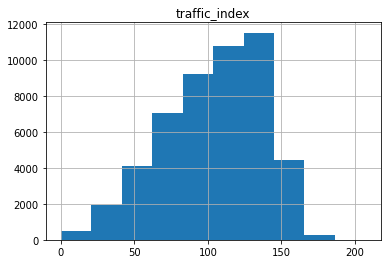

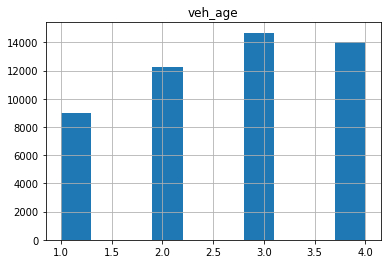

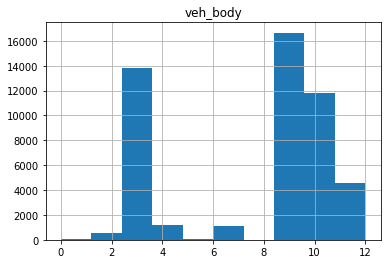

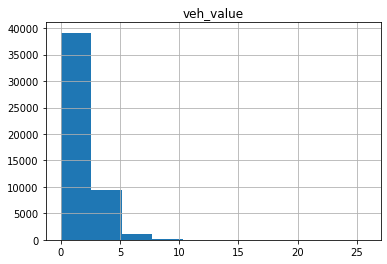

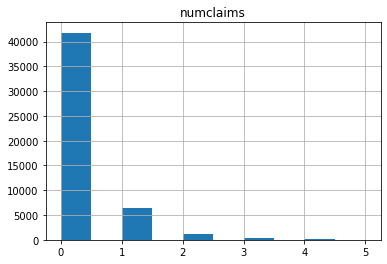

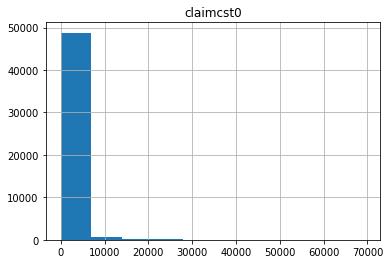

In [16]:
# Гистограммы

plt.figure(figsize=(10, 10))

cols = df_nums.columns
for col_i in cols:
    df_nums.hist(column=col_i)


# Кластеризация


In [17]:
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN
#from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.mixture import GaussianMixture as EM

from sklearn import metrics

from scipy.spatial.distance import pdist

from collections import defaultdict


RndState = 5051


## k-means

Ds = [0.472, 0.52, 0.555, 0.607, 0.74, 0.918, 0.617, 0.706, 0.895, 0.825], 
min = 0.472 with k = 1


Text(0, 0.5, '$J(C_k)$')

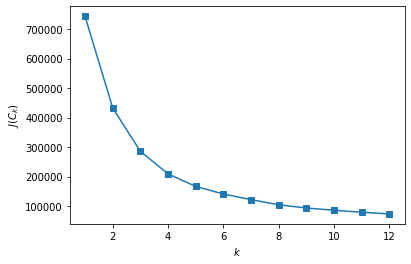

In [18]:
Js = [] # inertia
N_max = 13

for i in range(1, N_max):
    kmeans = KMeans(n_clusters=i, random_state=RndState).fit(df_nums)
    Js.append(np.sqrt(kmeans.inertia_))

Ds = []
for i in range(1, len(Js)-1):
    Ds.append( abs(Js[i] - Js[i+1]) / abs(Js[i-1] - Js[i]) )
Ds = [round(Ds[i], 3) for i in range(len(Ds))]
print(f"Ds = {Ds}, \nmin = {min(Ds)} with k = {Ds.index(min(Ds))+1}")
    
plt.plot(range(1, N_max), Js, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$")

Numbers of classes: {0: 44917, 1: 367, 2: 69, 3: 1100, 4: 108, 5: 49, 6: 2538, 7: 566, 8: 205}

=====
Silhouette says: 0.8420828180082512
=====


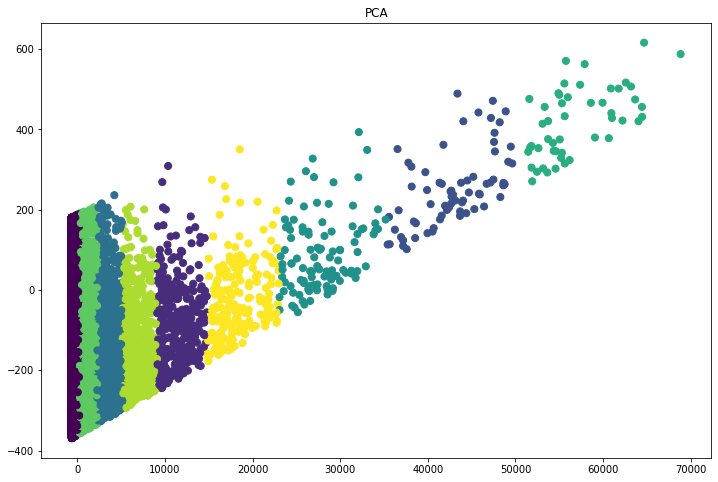

In [19]:
# Число кластеров 9 звучит хорошо
N_CLASTERS = 9
kmeans = KMeans(n_clusters=N_CLASTERS, random_state=RndState).fit(df_nums)

#print(f"kmeans.labels={len(kmeans.labels_)}, number of rows = {df_nums.shape[0]}")

d_classes = {i: 0 for i in range(N_CLASTERS)}
for i in kmeans.labels_:
    d_classes[i] += 1

print(f"Numbers of classes: {d_classes}")

pca = PCA(n_components=2)
res = pca.fit_transform(df_nums)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=kmeans.labels_, s=50, cmap='viridis')
plt.title('PCA')

print(f"\n=====\nSilhouette says: {metrics.silhouette_score(df_nums, kmeans.labels_)}\n=====") 
# From {-1} is super bad   --->   to {1} is super good

## Mean-Shift

In [20]:

df = df_nums_scaled.copy()

for bandwidth_i_int in range(5, 100, 10):
    bandwidth_i = bandwidth_i_int / 100
    flat_shift = MeanShift(bandwidth=bandwidth_i).fit(df)
    number_of_class = len(set(flat_shift.labels_))
    print(f"\nFor bandwidth={bandwidth_i} {number_of_class} classes")
    if(number_of_class < 15):
        d = defaultdict(lambda:0)
        for row_i in flat_shift.labels_:
            d[row_i] += 1
        print(f"\t{d}")



For bandwidth=0.05 29907 classes

For bandwidth=0.15 8449 classes

For bandwidth=0.25 1439 classes

For bandwidth=0.35 282 classes

For bandwidth=0.45 66 classes

For bandwidth=0.55 15 classes

For bandwidth=0.65 4 classes
	defaultdict(<function <lambda> at 0x7faa2c189ea0>, {0: 28386, 1: 21366, 2: 42, 3: 125})

For bandwidth=0.75 3 classes
	defaultdict(<function <lambda> at 0x7faa2c189e18>, {0: 28393, 1: 21486, 2: 40})

For bandwidth=0.85 2 classes
	defaultdict(<function <lambda> at 0x7faa2c189d90>, {0: 28431, 1: 21488})

For bandwidth=0.95 2 classes
	defaultdict(<function <lambda> at 0x7faa2c189e18>, {0: 28431, 1: 21488})


Numbers of classes: defaultdict(<function <lambda> at 0x7faa2d142ea0>, {0: 28216, 1: 20991, 4: 127, 3: 69, 7: 366, 5: 101, 6: 33, 2: 16})

=====
Silhouette says: 0.18526174983210825
=====


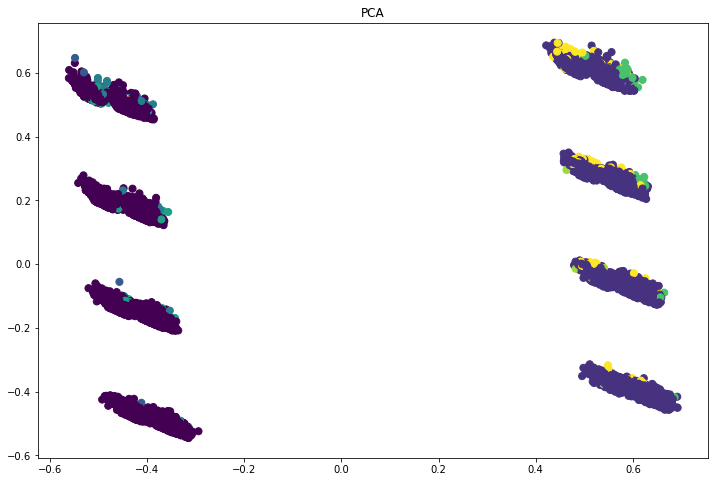

In [32]:
# Пусть bandwidth=0.6
flat_shift = MeanShift(bandwidth=0.6).fit(df_nums_scaled)
d = defaultdict(lambda:0)
for row_i in flat_shift.labels_:
    d[row_i] += 1

print(f"Numbers of classes: {d}")

pca = PCA(n_components=2)
res = pca.fit_transform(df_nums_scaled)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=flat_shift.labels_, s=50, cmap='viridis')
plt.title('PCA')

print(f"\n=====\nSilhouette says: {metrics.silhouette_score(df_nums_scaled, flat_shift.labels_)}\n=====")
# From {-1} is super bad   --->   to {1} is super good

## DBSCAN

In [22]:

df = df_nums_scaled.copy()

for eps_i_int in range(5, 50, 5):
    eps_i = eps_i_int / 100
    for min_samples_i in range(3, 9, 2):
        dbscan = DBSCAN(eps=eps_i, min_samples=min_samples_i).fit(df)
        number_of_class = len(set(dbscan.labels_))
        print(f"\nFor eps={eps_i} and min_samples={min_samples_i} {number_of_class} classes")
        if(number_of_class < 15):
            d = defaultdict(lambda:0)
            for row_i in dbscan.labels_:
                d[row_i] += 1
            print(f"\t{d}")
        


For eps=0.05 and min_samples=3 2086 classes

For eps=0.05 and min_samples=5 781 classes

For eps=0.05 and min_samples=7 406 classes

For eps=0.1 and min_samples=3 1596 classes

For eps=0.1 and min_samples=5 774 classes

For eps=0.1 and min_samples=7 506 classes

For eps=0.15 and min_samples=3 1372 classes

For eps=0.15 and min_samples=5 844 classes

For eps=0.15 and min_samples=7 634 classes

For eps=0.2 and min_samples=3 1118 classes

For eps=0.2 and min_samples=5 808 classes

For eps=0.2 and min_samples=7 660 classes

For eps=0.25 and min_samples=3 43 classes

For eps=0.25 and min_samples=5 14 classes
	defaultdict(<function <lambda> at 0x7faa2cefa2f0>, {0: 7246, 1: 2881, 2: 6583, 3: 5908, 4: 7151, 5: 8482, -1: 1290, 6: 4705, 7: 2537, 8: 2182, 9: 938, 11: 8, 10: 5, 12: 3})

For eps=0.25 and min_samples=7 14 classes
	defaultdict(<function <lambda> at 0x7faa2cefa598>, {0: 7234, 5: 2870, 1: 6536, 2: 5865, 3: 7126, 4: 8465, -1: 1549, 6: 4652, 7: 2503, 8: 2172, 9: 928, 12: 7, 10: 6, 11: 6

Numbers of classes: defaultdict(<function <lambda> at 0x7faa36120598>, {0: 7303, 1: 5126, 2: 6667, 3: 5987, 4: 7215, 5: 8537, 6: 4785, -1: 687, 7: 3606, 8: 6})

=====
Silhouette says: 0.08528389910239316
=====


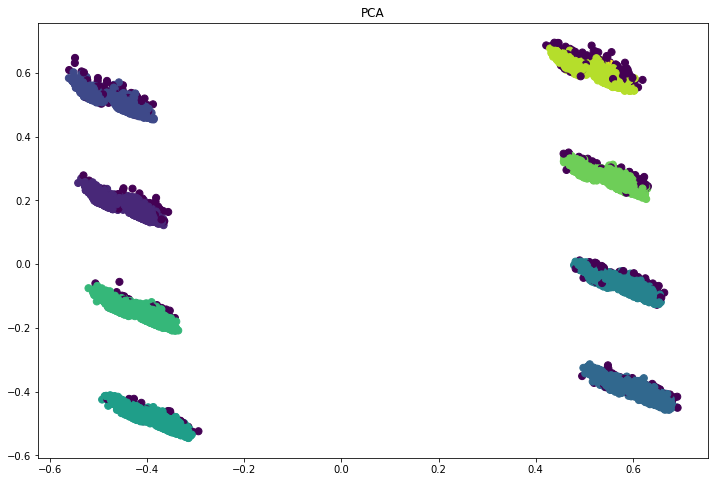

In [23]:
# Пусть eps=0.3 and min_samples=7
dbscan = DBSCAN(eps=0.3, min_samples=7).fit(df_nums_scaled)
d = defaultdict(lambda:0)
for row_i in dbscan.labels_:
    d[row_i] += 1

print(f"Numbers of classes: {d}")

pca = PCA(n_components=2)
res = pca.fit_transform(df_nums_scaled)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=dbscan.labels_, s=50, cmap='viridis')
plt.title('PCA')

print(f"\n=====\nSilhouette says: {metrics.silhouette_score(df_nums_scaled, dbscan.labels_)}\n=====")
# From {-1} is super bad   --->   to {1} is super good

## Иерархическая кластеризация

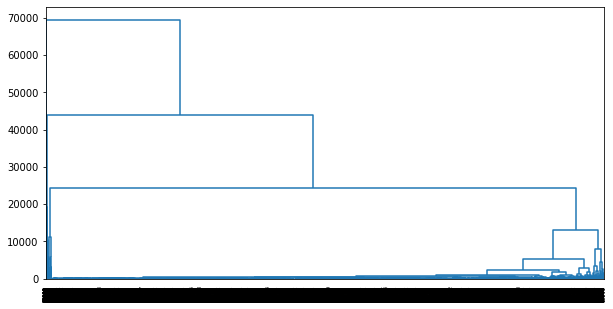

In [31]:
# верхний треугольник матрицы попарных расстояний
distance_mat = pdist(df_nums)
    

Z = hierarchy.linkage(distance_mat, "complete")
            # linkage — реализация агломеративного алгоритма
    
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z, color_threshold=0.5)


## EM

In [29]:
N_max = 13

for i in range(1, N_max):
    em = EM(n_components=i, random_state=RndState).fit(df_nums_scaled)
    pd.set_option('display.max_rows', i)
    print(f"\nFor n_components={i}: \n{pd.DataFrame(em.predict(df_nums_scaled)).value_counts()}")


For n_components=1: 
0    49919
dtype: int64

For n_components=2: 
0    28431
1    21488
dtype: int64

For n_components=3: 
0    28431
1    15963
2     5525
dtype: int64

For n_components=4: 
3    25674
1    15963
2     5525
0     2757
dtype: int64

For n_components=5: 
3    25674
1    15964
2     5524
4     1950
0      807
dtype: int64

For n_components=6: 
3    25675
1    15953
5     3912
4     1822
2     1623
0      934
dtype: int64

For n_components=7: 
3    25674
1    15954
2     4059
4     1945
0      812
6      775
5      700
dtype: int64

For n_components=8: 
2    16739
1    15953
7     8997
3     4014
5     1521
4     1154
0      902
6      639
dtype: int64

For n_components=9: 
2    16789
1    15954
7     8948
3     4059
4     1152
0      902
5      764
8      711
6      640
dtype: int64

For n_components=10: 
1    15954
2     9205
0     8742
6     5233
3     4064
4     2648
7     1499
9     1104
8      753
5      717
dtype: int64

For n_components=11: 
1     15953
0      87

Numbers of classes: {0: 902, 1: 15954, 2: 16789, 3: 4059, 4: 1152, 5: 764, 6: 640, 7: 8948, 8: 711}

=====
Silhouette says: 0.0473223620075407
=====


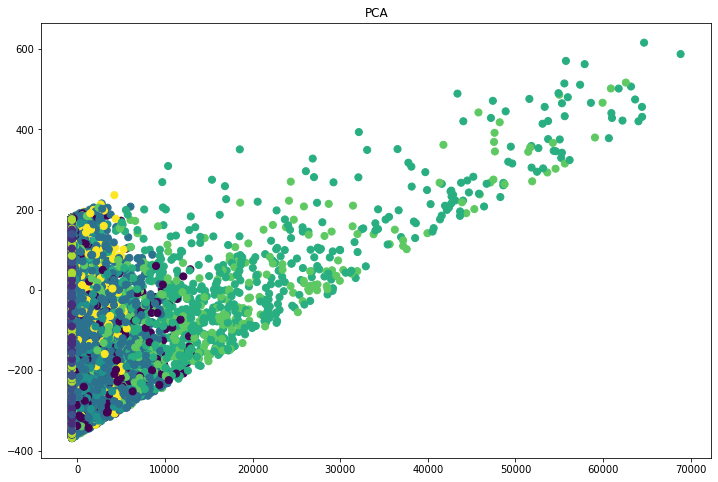

In [30]:
# Пусть n_components=9
N_CLASTERS = 9
em = EM(n_components=N_CLASTERS, random_state=RndState).fit(df_nums_scaled)

em_labels = em.predict(df_nums_scaled)
d_classes = {i: 0 for i in range(N_CLASTERS)}
for i in em_labels:
    d_classes[i] += 1

print(f"Numbers of classes: {d_classes}")

pca = PCA(n_components=2)
res = pca.fit_transform(df_nums)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=em.predict(df_nums_scaled), s=50, cmap='viridis')
plt.title('PCA')

print(f"\n=====\nSilhouette says: {metrics.silhouette_score(df_nums_scaled, em_labels)}\n=====")
# From {-1} is super bad   --->   to {1} is super good